In [5]:
import pandas as pd
import numpy as np
import os
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
import nibabel as nib

# Load your participants info
participants = pd.read_csv("groups.csv")

# Load an atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100)['maps']  # You can change n_rois
masker = NiftiLabelsMasker(labels_img=atlas, standardize=True, memory='nilearn_cache')

# Choose correlation method (Pearson here)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Store results
all_connectomes = []
groups = []

for idx, row in participants.iterrows():
    sub = row['ID']
    group = row['group']

    func_file = f'swm_fmri_data/{sub}_task-swm_run-1_desc-icclean+std_brain..nii.gz'

    if not os.path.exists(func_file):
        continue


    # Extract ROI time series
    time_series = masker.fit_transform(func_file)

    # Compute connectivity
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]

    all_connectomes.append(correlation_matrix)
    groups.append(group)

print("Connectivity matrices computed for all subjects.")

[get_dataset_dir] Dataset created in /home/nilayoh/nilearn_data/schaefer_2018

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_100Parcels_7Networks_order.txt ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.
nii.gz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

Connectivity matrices computed for all subjects.


[get_dataset_dir] Dataset created in /home/nilayoh/nilearn_data/aal_SPM12

[fetch_single_file] Downloading data from https://www.gin.cnrs.fr/AAL_files/aal_for_SPM12.tar.gz ...

[fetch_single_file]  ...done. (4 seconds, 0 min)

[uncompress_file] Extracting data from 
/home/nilayoh/nilearn_data/aal_SPM12/f1b913dc338bc2a6afbbd351634405fc/aal_for_SPM12.tar.gz...

[uncompress_file] .. done.

Processing sub-010_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-012_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-024_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-055_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-061_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-062_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-077_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1000301_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1000303_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1018301_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1018302_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1027302_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1027303_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1050303_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processing sub-1063302_task-swm_run-1_desc-icclean+std_brain.nii.gz
Processi

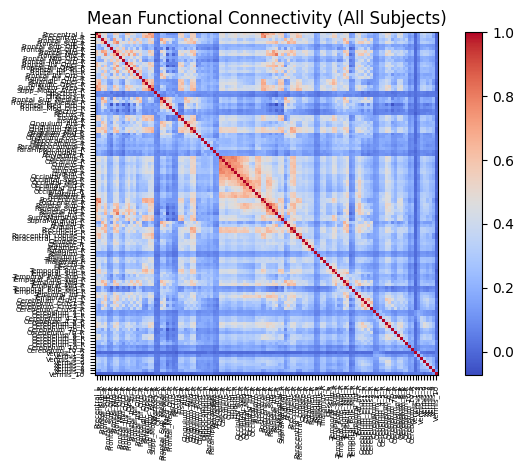

In [11]:
import os
import numpy as np
import pandas as pd
from nilearn import datasets, image, masking, connectome
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.pyplot as plt

# Set your data folder
data_dir = "/home/nilayoh/swm_fmri_data"  # change this to your actual path
subject_files = sorted([f for f in os.listdir(data_dir) if f.endswith('brain.nii.gz')])

# Load an atlas (AAL or Harvard-Oxford for MNI space)
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
labels = atlas.labels

# Initialize masker: extracts time series from each ROI
masker = NiftiLabelsMasker(labels_img=atlas_filename,
                           standardize=True, detrend=True,
                           low_pass=None, high_pass=None, t_r=2.0)  # Adjust TR if needed

# Create an empty list to store individual connectivity matrices
connectivity_matrices = []

for subj_file in subject_files:
    subj_path = os.path.join(data_dir, subj_file)
    print(f"Processing {subj_file}")

    # Load and extract ROI time series
    time_series = masker.fit_transform(subj_path)

    # Compute correlation matrix (functional connectivity)
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
    corr_matrix = correlation_measure.fit_transform([time_series])[0]

    connectivity_matrices.append(corr_matrix)

# Convert to NumPy array (N_subjects x N_ROIs x N_ROIs)
connectivity_matrices = np.array(connectivity_matrices)

# Optional: average matrix across subjects
group_mean_matrix = np.mean(connectivity_matrices, axis=0)

# Plot mean matrix
plt.imshow(group_mean_matrix, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.title('Mean Functional Connectivity (All Subjects)')
plt.xticks(range(len(labels)), labels, fontsize=5, rotation=90)
plt.yticks(range(len(labels)), labels, fontsize=5)
plt.tight_layout()
plt.show()

# Save results to disk
np.save("connectivity_matrices.npy", connectivity_matrices)


In [12]:
# Get indices for frontal and parietal ROIs
frontal_indices = [i for i, label in enumerate(labels) if 'Frontal' in label or 'Precentral' in label]
parietal_indices = [i for i, label in enumerate(labels) if 'Parietal' in label or 'Postcentral' in label]

print("Frontal ROIs:", [labels[i] for i in frontal_indices])
print("Parietal ROIs:", [labels[i] for i in parietal_indices])
# Extract frontal-parietal connectivity for each subject
fp_connectivity = connectivity_matrices[:, :, :][:, frontal_indices][:, :, parietal_indices]

# fp_connectivity shape: (n_subjects, n_frontal, n_parietal)
print("Shape of frontoparietal data:", fp_connectivity.shape)

# Save for later
np.save("frontoparietal_connectivity.npy", fp_connectivity)

Frontal ROIs: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R']
Parietal ROIs: ['Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R']
Shape of frontoparietal data: (68, 20, 6)


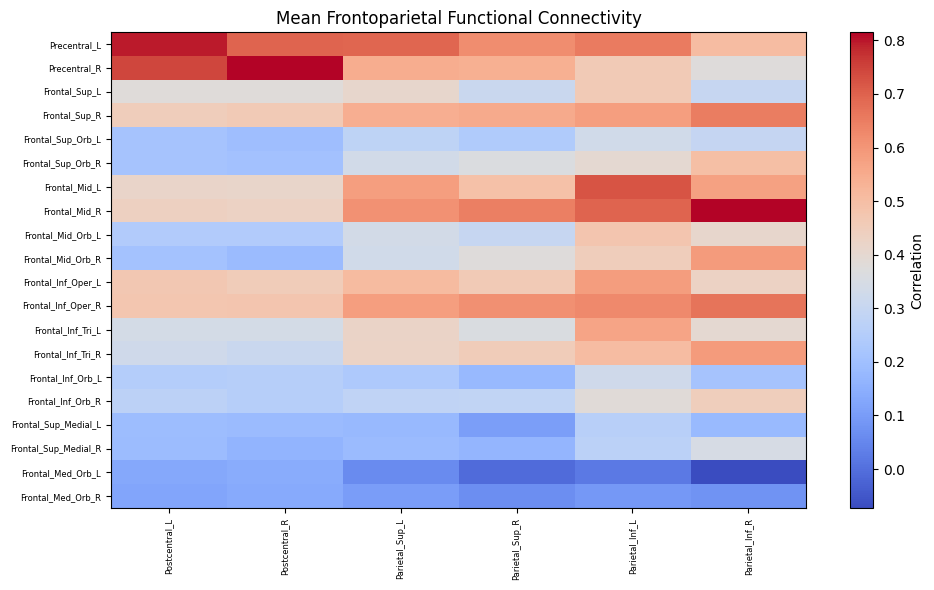

In [13]:
mean_fp = np.mean(fp_connectivity, axis=0)  # shape: (n_frontal, n_parietal)

plt.figure(figsize=(10, 6))
plt.imshow(mean_fp, cmap='coolwarm', aspect='auto')
plt.colorbar(label="Correlation")
plt.title("Mean Frontoparietal Functional Connectivity")
plt.xticks(range(len(parietal_indices)), [labels[i] for i in parietal_indices], rotation=90, fontsize=6)
plt.yticks(range(len(frontal_indices)), [labels[i] for i in frontal_indices], fontsize=6)
plt.tight_layout()
plt.show()

In [19]:
# Load groups.csv
groups_df = pd.read_csv("groups.csv")

# Extract just subject IDs from filenames
subject_ids = [f.split('_')[0] for f in subject_files]

# Match group labels to subjects
groups_df = groups_df.set_index('ID')
subject_groups = [groups_df.loc[s, 'group'] for s in subject_ids]

# Convert to numpy array
subject_groups = np.array(subject_groups)

In [20]:
# Convert connectivity to numpy if not already
fp_conn = np.load("frontoparietal_connectivity.npy")  # or use your in-memory variable

# Find group indices
adhd_idx = np.where(subject_groups == 'ADHD')[0]
ctrl_idx = np.where(subject_groups == 'Control')[0]

# Split data
fp_adhd = fp_conn[adhd_idx]     # shape: (n_adhd, n_frontal, n_parietal)
fp_ctrl = fp_conn[ctrl_idx]     # shape: (n_ctrl, n_frontal, n_parietal)

In [21]:
from scipy.stats import ttest_ind

n_f, n_p = fp_conn.shape[1:3]
t_vals = np.zeros((n_f, n_p))
p_vals = np.zeros((n_f, n_p))

for i in range(n_f):
    for j in range(n_p):
        t, p = ttest_ind(fp_adhd[:, i, j], fp_ctrl[:, i, j])
        t_vals[i, j] = t
        p_vals[i, j] = p

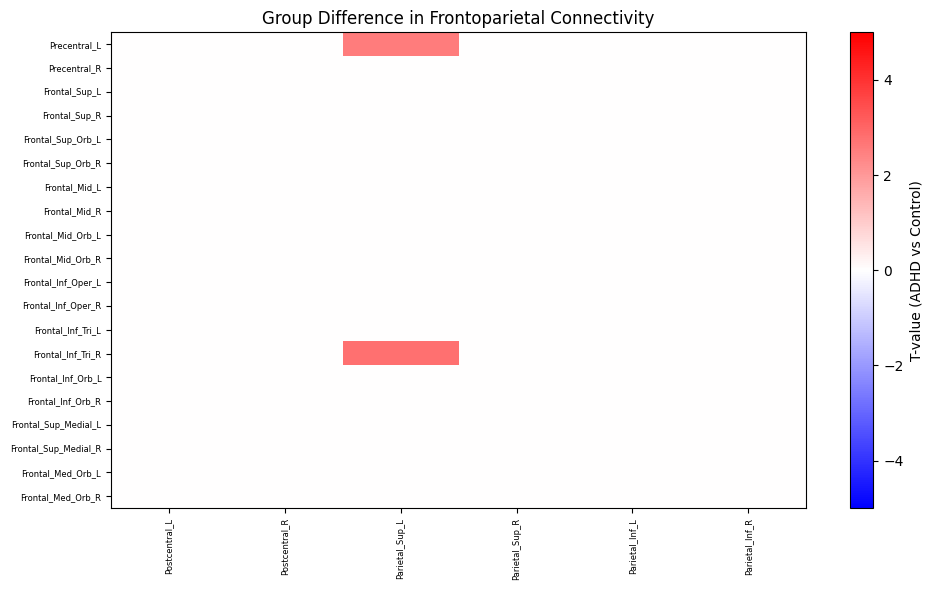

In [22]:
# Optional: Threshold by p-value (e.g., p < 0.05 uncorrected)
significant_mask = p_vals < 0.05

plt.figure(figsize=(10, 6))
plt.imshow(t_vals * significant_mask, cmap='bwr', aspect='auto', vmin=-5, vmax=5)
plt.colorbar(label="T-value (ADHD vs Control)")
plt.title("Group Difference in Frontoparietal Connectivity")

plt.xticks(range(n_p), [labels[i] for i in parietal_indices], rotation=90, fontsize=6)
plt.yticks(range(n_f), [labels[i] for i in frontal_indices], fontsize=6)

plt.tight_layout()
plt.show()

In [23]:
import numpy as np

# Average FP connectivity per subject: mean over frontal × parietal dimensions
fp_adhd_avg = fp_adhd.mean(axis=(1, 2))   # shape: (n_adhd,)
fp_ctrl_avg = fp_ctrl.mean(axis=(1, 2))   # shape: (n_ctrl,)

# Print group-level means and standard deviations
print("ADHD group - mean FP connectivity:", fp_adhd_avg.mean(), "±", fp_adhd_avg.std())
print("Control group - mean FP connectivity:", fp_ctrl_avg.mean(), "±", fp_ctrl_avg.std())

ADHD group - mean FP connectivity: 0.38335684 ± 0.13230598
Control group - mean FP connectivity: 0.37404302 ± 0.12855603


In [24]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(fp_adhd_avg, fp_ctrl_avg)
print(f"T-test: t = {t_stat:.3f}, p = {p_val:.3f}")

T-test: t = 0.286, p = 0.776


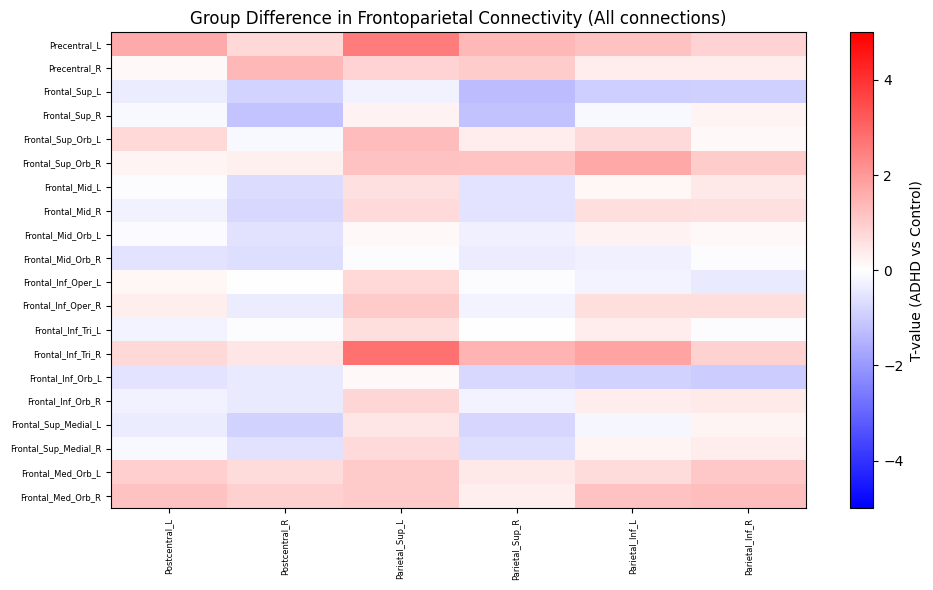

In [25]:
plt.figure(figsize=(10, 6))
plt.imshow(t_vals, cmap='bwr', aspect='auto', vmin=-5, vmax=5)  # Show all t-values
plt.colorbar(label="T-value (ADHD vs Control)")
plt.title("Group Difference in Frontoparietal Connectivity (All connections)")

plt.xticks(range(n_p), [labels[i] for i in parietal_indices], rotation=90, fontsize=6)
plt.yticks(range(n_f), [labels[i] for i in frontal_indices], fontsize=6)

plt.tight_layout()
plt.show()

In [27]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 7.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00
